In [1]:
# Import necessary libraries
import numpy as np                 # Numerical operations and array handling
import random                      # Random number generation
import matplotlib.pyplot as plt    # Plotting and visualization
import seaborn as sns              # Statistical data visualization based on Matplotlib
import pandas as pd                # Data manipulation and analysis tools
from scipy.stats import ttest_rel  # Paired t-test for statistical analysis
import time                        # Timing and performance measurement

In [2]:
# Function to calculate load carrying capacity
def W(x):
    return (np.pi * P0(x) / 2) * ((x[2]**2 - x[1]**2) / np.log(np.clip(x[2] / x[1], 1e-10, None)))

# Function to calculate inlet pressure
def P0(x):
    return (((6 * 10**-6 * x[3] * x[0]) * (np.log(np.clip(x[2] / x[1], 1e-10, None)))) / (np.pi * h(x)**3))

# Function to calculate friction loss
def Ef(x):
    return 143.308 * DeltaT(x) * x[0]

# Function to calculate temperature difference
def DeltaT(x):
    return 2 * (10**P(x) - 560)

# Function to calculate pressure
def P(x):
    arg = 8.122 * x[3] + 0.8
    if arg <= 0:
        return np.nan  # or any other suitable value to indicate an invalid result
    return (np.log10(np.log10(arg)) - 10.04) / -3.55

# Function to calculate oil thickness
def h(x):
    return (((1500 * np.pi) / 60)**2) * (((2 * 10**-6 * np.pi * x[3]) / Ef(x)) * ((x[2]**4 - x[1]**4) / 4))


In [3]:
# Example values for the decision vector
Q_value = 4.19
R0_value = 11.57
R_value = 6.69
mu_value = 10.65

# Create a numpy array with example values
x_ex = np.array([Q_value, R0_value, R_value, mu_value])

# Calculate results using the defined functions
result_W = W(x_ex)
result_P0 = P0(x_ex)
result_Ef = Ef(x_ex)
result_DeltaT = DeltaT(x_ex)
result_P = P(x_ex)
result_h = h(x_ex)

# Print the results
print(f'W(x): {result_W}')
print(f'P0(x): {result_P0}')
print(f'Ef(x): {result_Ef}')
print(f'DeltaT(x): {result_DeltaT}')
print(f'P(x): {result_P}')
print(f'h(x): {result_h}')


W(x): -0.015287595429129719
P0(x): -5.983042094105245e-05
Ef(x): -1784.0769925953873
DeltaT(x): -2.971181173735431
P(x): 2.747034382192692
h(x): 0.9206377239881502


In [4]:
# Task 1 - Implementation of the functions

# Function f(x)
def f(x):
    return (P0(x) * x[0]) / 0.7 + Ef(x)

# Constraints g1(x) to g7(x)
# Function to calculate weight capacity
def g1(x):
    return 101000 - W(x)

# Function to calculate inlet oil pressure
def g2(x):
    return P0(x) - 1000

# Function to calculate oil temperature rise
def g3(x):
    return DeltaT(x) - 50

# Function to calculate oil film thickness 
def g4(x):
    return 0.001 - h(x)

def g5(x):
    return x[1] - x[2]

# Function to calculate exit loss
def g6(x):
    return ((0.0307 * x[0])/(772.8 * np.pi * P0(x) * h(x) * x[2])) - 0.001

# Function to calculate contact pressure
def g7(x):
    return (W(x) / (np.pi * (x[2]**2 - x[1]**2))) - 5000

In [5]:
x_ex = np.array([Q_value, R0_value, R_value, mu_value])  # Replace with actual values
result_f = f(x_ex)
result_g1 = g1(x_ex)
result_g2 = g2(x_ex)
result_g3 = g3(x_ex)
result_g4 = g4(x_ex)
result_g5 = g5(x_ex)
result_g6 = g6(x_ex)
result_g7 = g7(x_ex)

# Print the results
print(f'f(x): {result_f}')
print(f'g1(x): {result_g1}')
print(f'g2(x): {result_g2}')
print(f'g3(x): {result_g3}')
print(f'g4(x): {result_g4}')
print(f'g5(x): {result_g5}')
print(f'g6(x): {result_g6}')
print(f'g7(x): {result_g7}')

f(x): -1784.0773507231927
g1(x): 101000.01528759542
g2(x): -1000.0000598304209
g3(x): -52.97118117373543
g4(x): -0.9196377239881502
g5(x): 4.88
g6(x): -0.14477999681964235
g7(x): -4999.999945390436


In [6]:
# Task 2 - Implementation of the Random Search (RS)

def random_search(objective_function, constraints, penalty_factor=1e6, num_iterations=10000, seed=None):
    np.random.seed(seed)

    best_solution = None
    best_objective_value = np.inf

    for _ in range(num_iterations):
        candidate_solution = np.random.uniform(low=[1, 1, 1, 1], high=[16, 16, 16, 16])

        # Apply penalty for violating constraints
        penalty_term = sum(max(0, constraint(candidate_solution)) for constraint in constraints)
        objective_value = objective_function(candidate_solution) + penalty_factor * penalty_term

        # Check if the candidate solution satisfies constraints
        if all(constraint(candidate_solution) <= 0 for constraint in constraints):
            # Update the best solution if the current one is better
            if objective_value < best_objective_value:
                best_solution = candidate_solution
                best_objective_value = objective_value

    return best_solution, best_objective_value

In [7]:
constraints_list = [g1, g2, g3, g4, g5, g6, g7]

In [8]:
# Example usage with penalty function
best_solution, best_objective_value = random_search(f, constraints_list, penalty_factor=1e6, num_iterations=10000, seed=55)

print("Best Solution:", best_solution)
print("Best Objective Value:", best_objective_value)

Best Solution: [9.90091195 7.0871234  7.79804603 7.51275279]
Best Objective Value: 42203.04628364858


In [9]:
# Task 3 - Implementation of simulated annealing (SA)

def simulated_annealing(objective_function, constraints, penalty_factor=1e6, initial_temperature=100.0, cooling_rate=0.50, num_iterations=10000, seed=None):
    np.random.seed(seed)

    current_solution = np.random.uniform(low=[1, 1, 1, 1], high=[16, 16, 16, 16])
    best_solution = current_solution
    temperature = initial_temperature

    for iteration in range(num_iterations):
        # Generate a candidate solution using normal distribution
        candidate_solution = current_solution + np.random.normal(scale=temperature, size=len(current_solution))

        # Apply death penalty for violating constraints
        penalty_term = sum(max(0, constraint(candidate_solution)) for constraint in constraints)
        candidate_objective_value = max(0, objective_function(candidate_solution)) + penalty_factor * penalty_term

        # Check if the candidate objective value is valid
        if not np.isfinite(candidate_objective_value):
            continue  # Skip this iteration if the objective value is invalid

        # Calculate acceptance probability
        acceptance_prob = np.exp((objective_function(current_solution) - candidate_objective_value) / temperature)

        # Accept or reject the candidate solution probabilistically
        if (candidate_objective_value < objective_function(current_solution)) or (np.random.rand() < acceptance_prob):
            current_solution = candidate_solution

        # Update the best solution if the current one is better
        if objective_function(current_solution) < objective_function(best_solution):
            best_solution = current_solution

        # Cool down the temperature
        temperature *= cooling_rate

    return best_solution, objective_function(best_solution)

In [10]:
# Example usage with simulated annealing
best_solution_sa, best_objective_value_sa = simulated_annealing(f, constraints_list, penalty_factor=1e6, initial_temperature=100.0, cooling_rate=0.95, num_iterations=10000, seed=123)

print("Best Solution (Simulated Annealing):", best_solution_sa)
print("Best Objective Value (Simulated Annealing):", best_objective_value_sa)

Best Solution (Simulated Annealing): [11.44703778  5.29209002  4.4027718   9.26972154]
Best Objective Value (Simulated Annealing): 29213.148056372847


In [11]:
# Task 4 - compare and comment on the performances of these optimisers

def run_optimization_algorithm(algorithm, repetitions, objective_function, constraints, num_iterations=10000, seed=None):
    total_runtimes = []
    best_objective_values = []

    for i in range(repetitions):
        current_seed = [33, 37, 40, 42, 43, 44, 54, 55, 57, 76, 94, 105, 107, 114, 120, 122, 123, 141, 143, 144, 146]
        start_time = time.time()
        best_solution, best_objective_value = algorithm(objective_function, constraints, penalty_factor=1e6, num_iterations=10000, seed=current_seed[i])
        print("Best Objective Value for ", current_seed[i], ":" , best_objective_value)
        end_time = time.time()

        total_runtimes.append(end_time - start_time)
        best_objective_values.append(best_objective_value)

    return total_runtimes, best_objective_values

In [12]:
# Run Random Search for 21 repetitions with different seeds
print("Best Objective Value for Random Search")
print()
rs_runtimes, rs_objective_values = run_optimization_algorithm(random_search, 21, f, constraints_list, num_iterations=10000, seed=55)
print()

# Run Simulated Annealing for 21 repetitions with different seeds
print("Best Objective Value for simulated annealing")
print()
sa_runtimes, sa_objective_values = run_optimization_algorithm(simulated_annealing, 21, f, constraints_list, num_iterations=10000, seed=55)
print()

# Combine the results for box plot
all_results = rs_objective_values + sa_objective_values
all_labels = ['Random Search'] * len(rs_objective_values) + ['Simulated Annealing'] * len(sa_objective_values)

# Create a DataFrame
data = pd.DataFrame({'Optimizer': all_labels, 'Objective Value': all_results})

Best Objective Value for Random Search

Best Objective Value for  33 : 55383.27044941318
Best Objective Value for  37 : 40769.898591359524
Best Objective Value for  40 : 38779.22119150019
Best Objective Value for  42 : 44355.43426902738
Best Objective Value for  43 : 51820.45475063368
Best Objective Value for  44 : 36337.55374059112
Best Objective Value for  54 : 56818.04084088361
Best Objective Value for  55 : 42203.04628364858
Best Objective Value for  57 : 68371.78789556821
Best Objective Value for  76 : 53341.91486818714
Best Objective Value for  94 : 45540.00066773138
Best Objective Value for  105 : 63728.32388101222
Best Objective Value for  107 : 46142.2681736943
Best Objective Value for  114 : 77430.29229369742
Best Objective Value for  120 : 70430.36854725468
Best Objective Value for  122 : 39202.015228756296
Best Objective Value for  123 : 50761.56301026706
Best Objective Value for  141 : 30709.232303107485
Best Objective Value for  143 : 62091.42324557705
Best Objective Valu

C:\Users\WIN10\AppData\Local\Temp\ipykernel_12208\3465671801.py:23: RuntimeWarning: overflow encountered in exp
  acceptance_prob = np.exp((objective_function(current_solution) - candidate_objective_value) / temperature)


Best Objective Value for  33 : 53260.761877475874


C:\Users\WIN10\AppData\Local\Temp\ipykernel_12208\3465671801.py:23: RuntimeWarning: overflow encountered in scalar divide
  acceptance_prob = np.exp((objective_function(current_solution) - candidate_objective_value) / temperature)
C:\Users\WIN10\AppData\Local\Temp\ipykernel_12208\3465671801.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = np.exp((objective_function(current_solution) - candidate_objective_value) / temperature)


Best Objective Value for  37 : 7477.968241862476
Best Objective Value for  40 : 51860.086341097296
Best Objective Value for  42 : 1520.564120192851
Best Objective Value for  43 : 24696.558587294378
Best Objective Value for  44 : 68758.63874442152
Best Objective Value for  54 : 11889.258562160976
Best Objective Value for  55 : 21506.61175231023
Best Objective Value for  57 : 15083.73054270584
Best Objective Value for  76 : 63678.64748914076
Best Objective Value for  94 : 41296.29144518208
Best Objective Value for  105 : 38909.52165624135
Best Objective Value for  107 : 33434.809371295676
Best Objective Value for  114 : 6946.908939088708
Best Objective Value for  120 : 26249.02741610519
Best Objective Value for  122 : 9600.779574834205
Best Objective Value for  123 : 29213.148056372847
Best Objective Value for  141 : 64860.271154215625
Best Objective Value for  143 : 49586.1335767283
Best Objective Value for  144 : 29633.069478559122
Best Objective Value for  146 : 71639.99320258788



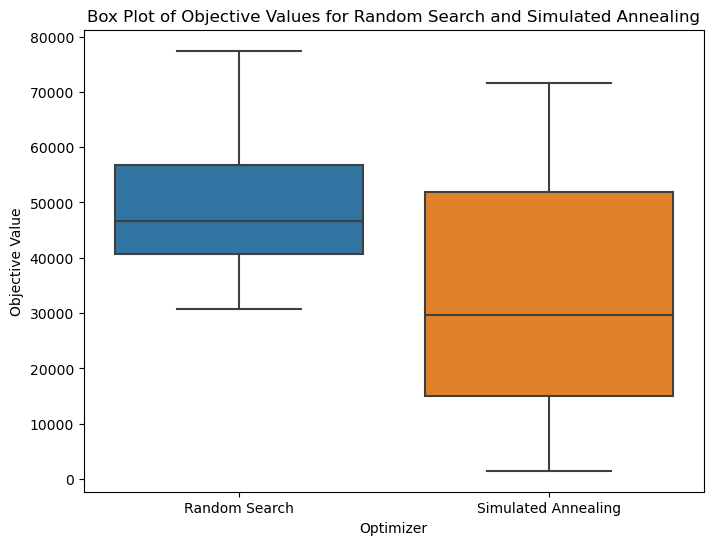

In [13]:
# Create a box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Optimizer', y='Objective Value', data=data)
plt.title('Box Plot of Objective Values for Random Search and Simulated Annealing')
plt.ylabel('Objective Value')
plt.show()

In [14]:
# Perform a paired t-test
t_statistic, p_value = ttest_rel(rs_objective_values, sa_objective_values)
print(f'T-Statistic: {t_statistic}')
print(f'P-Value: {p_value}')

T-Statistic: 2.541932598305164
P-Value: 0.019410124275262824


In [15]:
# Interpret the statistical test result
alpha = 0.05
if p_value < alpha:
    print('The difference in performance is statistically significant.')
else:
    print('There is no statistically significant difference in performance.')

The difference in performance is statistically significant.


In [16]:
print("The observed differences in performance between Random Search and Simulated Annealing are statistically significant or if they could have occurred by chance. If the p-value is below the chosen significance level (here, 0.05), it suggests that the observed differences are unlikely to be due to random chance, and the conclusion is that there is a statistically significant difference in performance between the two optimization algorithms. If the p-value is above the significance level, the code concludes that there is no statistically significant difference.")

The observed differences in performance between Random Search and Simulated Annealing are statistically significant or if they could have occurred by chance. If the p-value is below the chosen significance level (here, 0.05), it suggests that the observed differences are unlikely to be due to random chance, and the conclusion is that there is a statistically significant difference in performance between the two optimization algorithms. If the p-value is above the significance level, the code concludes that there is no statistically significant difference.
